# Gaussian Naive Bayes

The Naive Bayes Classifier is based on Bayes' theorem. Here we explore Gaussian Naive Bayes.

## Statistics behind Naive Bayes
This classifier works off the assumption that the features are independent of eachother. In reality, it's likely that the features are not independent, but Gaussian Naive Bayes can still work well in this scenario. As we have assumed independence, we can use Bayes' theorem, that is,

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}.
$$

Here $A$ and $B$ are two independent events, $P(A|B)$ is the probability of A conditioned on B, $P(A), P(B)$ the probabilities of A and B occuring.

This theorem only involved two events, but we can use this simplified version to explain how the classifier works. First it calculates the mean and variance for each class, and uses this to calculate the distribution of each feature in each class. Here it also assumes that the features follow a normal distribution. Then to classify data points with a particular set of features it calculates the likelihood of observing those features for each class. Then it uses Bayes' Theorem to choose the class with the highest probability given the features. [1]

## The Zero Probability Phenomenom
There can be a scenario where a particular feature value or combination of feature values is not observed in the training data. This leads to the conditional probability being zero for that combination in a class which causes problems during classification. To resolve this issue, the Naive Bayes model uses a technique called Laplace Smoothing. This adds a small positive value (for example 1) to the count for each feature within each class. This prevents the zero probability phenomenom and allows the model to better predict unobserved feature combinations, improving overall accuracy. [2]

In [1]:
# Gaussian Naive Bayes Classification
!pip install matplotlib seaborn scikit-learn
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

  Using cached matplotlib-3.8.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)
  Using cached scikit_learn-1.3.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
  Using cached kiwisolver-1.4.5-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached fonttools-4.44.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.5 MB)
  Using cached Pillow-10.1.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.6 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached contourpy-1.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (310 kB)
  Using cached pandas-2.1.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached scipy-1.11.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.6 MB)
  Using cached tzd

In [2]:
# read in the pre split test and train data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

## Feature Scaling
To prepare the data for the Gaussian Naive Bayes classifier, we map the features onto the same scale.

In [3]:
cols = X_train.columns

In [4]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [5]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [6]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [7]:
X_train.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,-0.8,-0.25,0.111111,-0.428571,1.5,0.666667,-1.176471,1.50,-0.022200,-1.446438,-0.203109,-1.145572,-1.691660,-0.181818,-0.285714,0.000000,0.0,0.0,-0.6250,0.157647
1,1.0,0.00,-0.222222,-0.285714,0.0,-0.111111,0.147059,-0.25,0.967596,-0.794997,0.893299,-0.365188,2.313526,-0.545455,0.285714,0.000000,0.0,0.0,-0.5625,-0.263529
2,0.8,0.50,0.666667,0.714286,-0.5,0.000000,0.441176,-0.75,0.981243,-0.052746,0.968026,0.000000,1.000000,-0.818182,-0.321429,0.000000,0.0,0.0,-0.6875,-0.472941
3,0.2,0.50,0.666667,0.714286,-0.5,-0.111111,0.441176,-0.75,1.179808,0.104405,0.968026,0.000000,1.000000,-0.909091,-0.321429,0.000000,0.0,0.0,0.5625,-0.263529
4,-0.4,-0.75,-0.555556,0.714286,-0.5,-0.444444,0.132353,0.00,-0.006886,0.444807,0.000000,0.126130,0.000000,-0.818182,-0.321429,8.428571,0.0,0.0,-0.4375,0.630588


## Model Training

In [8]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB


# instantiate the model
gnb = GaussianNB()


# fit the model
gnb.fit(X_train, y_train)

GaussianNB()

In [9]:
y_pred = gnb.predict(X_test)

y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [10]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.7921


## Check for overfitting

In [11]:
y_pred_train = gnb.predict(X_train)

y_pred_train

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.7910


As the training set and test set scores are close, there is no evidence of overfitting

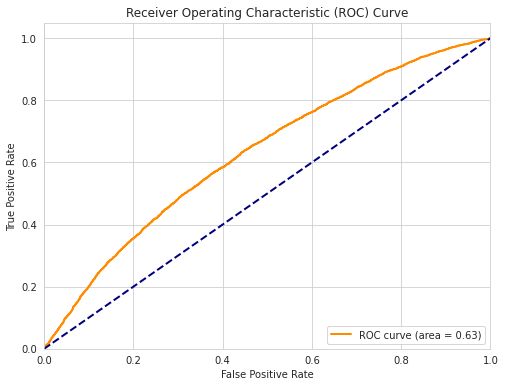

In [13]:
# plot ROC Curve
from sklearn.metrics import roc_curve, auc
y_scores = gnb.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
# write predictions and probabilities to csv files
y_scores = gnb.predict_proba(X_test)[:, 1]
y_pred = gnb.predict(X_test)

# Create DataFrames for predictions and predicted probabilities
predictions_df = pd.DataFrame({'Prediction': y_pred})
probabilities_df = pd.DataFrame({'Predicted Probabilities': y_scores})

# Save DataFrames to CSV files
predictions_df.to_csv('NaiveBayes_Unbalanced_Predictions.csv', index=False)
probabilities_df.to_csv('NaiveBayes_Unbalanced_Probabilities.csv', index=False)

## Balanced data
Now we also test the model on the SMOTE balanced data.

In [15]:
X_smote_train = pd.read_csv('X_smote_train.csv')
X_smote_test = pd.read_csv('X_smote_test.csv')
y_smote_train = pd.read_csv('y_smote_train.csv')
y_smote_test = pd.read_csv('y_smote_test.csv')

In [16]:
# check the shape of X_train and X_test

X_smote_train.shape, X_smote_test.shape

((162313, 20), (40579, 20))

In [17]:
cols = X_smote_train.columns

In [18]:
scaler = RobustScaler()

X_smote_train = scaler.fit_transform(X_smote_train)

X_smote_test = scaler.transform(X_smote_test)

In [19]:
X_smote_train = pd.DataFrame(X_smote_train, columns=[cols])
X_smote_test = pd.DataFrame(X_smote_test, columns=[cols])

In [20]:
X_smote_train.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,0.4,0.333333,-0.222222,0.142857,1.0,-0.125,-0.569444,-0.75,1.179808,0.079521,0.968026,0.000000,1.000000,-1.000000,1.285714,0.000000,0.000000,0.0,0.514286,-0.336270
1,1.2,-0.333333,0.444444,-0.428571,1.0,-0.500,-1.027778,0.50,-0.038573,-0.649237,-0.206508,-2.331626,-1.530392,-0.545455,0.321429,2.894208,0.075869,0.0,-0.657143,1.773586
2,0.4,1.000000,-0.222222,0.857143,-0.5,0.000,0.000000,0.00,0.000000,0.488562,0.000000,0.256718,0.000000,0.363636,-0.428571,0.000000,0.000000,0.0,0.514286,-0.607367
3,0.2,-0.666667,-0.333333,0.285714,-0.5,0.875,0.000000,0.00,-0.002295,0.491830,0.000000,0.256718,0.000000,0.636364,-0.428571,0.000000,0.000000,0.0,0.857143,-0.049673
4,0.6,0.000000,0.111111,-0.142857,0.0,0.000,0.694444,0.00,-0.029266,0.385076,0.000000,0.256718,0.000000,-0.727273,0.250000,0.000000,0.000000,0.0,0.257143,-0.203208


In [21]:
# initiate the model
gnb = GaussianNB()
# fit the model
gnb.fit(X_smote_train, y_smote_train)

GaussianNB()

In [22]:
y_pred = gnb.predict(X_smote_test)

y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_smote_test, y_pred)))

Model accuracy score: 0.5692


In [24]:
y_pred_train = gnb.predict(X_smote_train)

y_pred_train

array([0, 1, 0, ..., 0, 0, 0])

In [25]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_smote_train, y_pred_train)))

Training-set accuracy score: 0.5653


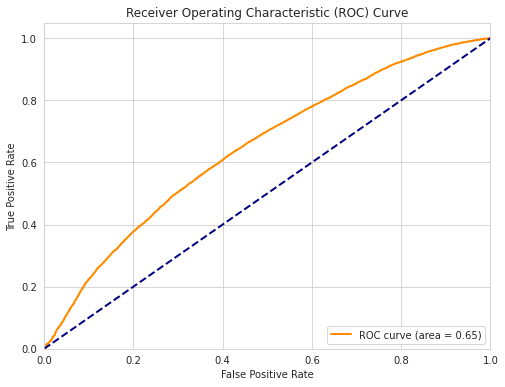

In [26]:
# plot ROC Curve
from sklearn.metrics import roc_curve, auc
y_scores = gnb.predict_proba(X_smote_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_smote_test, y_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

So we can see using the balanced data we get a higher ROC AUC but a lower accuracy. This suggests the accuracy alone is not the most appropriate metric. This drop in accuracy could be caused by the oversampling of the minority class. With the unbalanced data the classifier could have a bias towards the majority class. The balancing causes this bias to reduce, and may lead to miscalculating more false positives for the minority class. As a result of this, it is better to look at the ROC AUC to provide a better assessment of the classifier's performance.

## Hyperparameter Tuning
As previously stated, the model assumes the features are normally distributed, which in reality is unlikely. We can use the PowerTransformer function on the features to make them closer to normally distributed which should improve the performance of the model. [3]

In [27]:
np.logspace(0,-9, num=10)

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])

In [28]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [29]:
from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=gnb, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_smote_test)

gs_NB.fit(Data_transformed, y_smote_test)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=1)

In [30]:
gs_NB.best_params_

{'var_smoothing': 1.0}

In [31]:
gs_NB.best_score_

0.5944782568954715

In [32]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

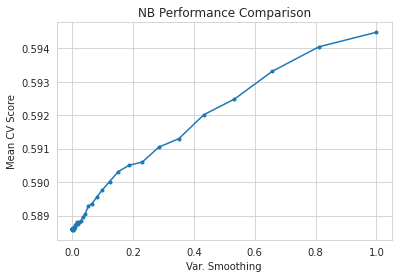

In [33]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [34]:
# predict the target on the test dataset
predict_test = gs_NB.predict(Data_transformed)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_smote_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.5947904088321546


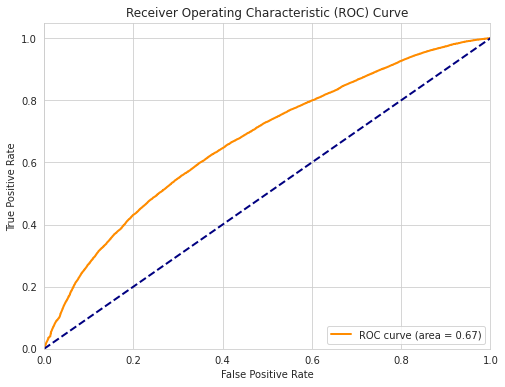

In [35]:
# plot ROC Curve
from sklearn.metrics import roc_curve, auc
y_scores = gs_NB.predict_proba(Data_transformed)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_smote_test, y_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

We can see we have increased the ROC AUC using hyperparameter tuning.

In [36]:
# initiate the model
gnb = GaussianNB()
# fit the model
gnb.fit(X_smote_train, y_smote_train)

GaussianNB()

In [37]:
y_pred = gnb.predict(X_test)

y_pred

array([1, 0, 0, ..., 0, 1, 0])

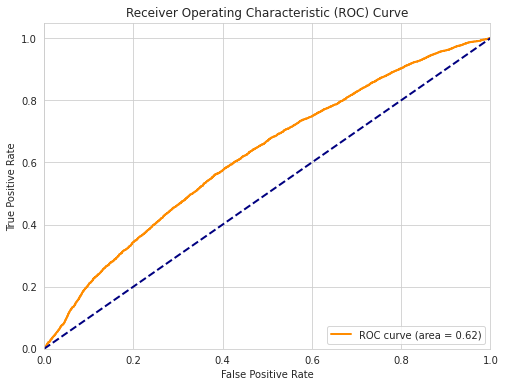

In [38]:
# plot ROC Curve
from sklearn.metrics import roc_curve, auc
y_scores = gnb.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [40]:
# write predictions and probabilities to csv files
y_scores = gs_NB.predict_proba(X_test)[:, 1]
y_pred = gs_NB.predict(X_test)

# Create DataFrames for predictions and predicted probabilities
predictions_df = pd.DataFrame({'Prediction': y_pred})
probabilities_df = pd.DataFrame({'Predicted Probabilities': y_scores})

# Save DataFrames to CSV files
predictions_df.to_csv('NaiveBayes_Balanced_Predictions.csv', index=False)
probabilities_df.to_csv('NaiveBayes_Balanced_Probabilities.csv', index=False)

## References
- [1] Geoffrey I Webb, "Naïve Bayes", 2017, https://www.researchgate.net/profile/Geoffrey-Webb/publication/306313918_Naive_Bayes/links/5cab15724585157bd32a75b6/Naive-Bayes.pdf <a id="ref1"></a>
- [2] Nagesh Singh Chauhan, "Naïve Bayes Algorithm: Everything You Need to Know", 2022, https://www.kdnuggets.com/2020/06/naive-bayes-algorithm-everything.html#:~:text=The%20Zero%2DFrequency%20Problem,all%20the%20probabilities%20are%20multiplied. <a id="ref2"></a>
- [3] Jason Brownlee, "How to Use Power Transforms for Machine Learning", 2020, https://machinelearningmastery.com/power-transforms-with-scikit-learn/ <a id="ref3"></a>
